In [1]:
%matplotlib inline
from scipy.stats import ttest_ind

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc
import numpy as np

from sctools import score


def subsample_dataframe(df, groupby, n_samples_per_group):
    subsampled_frames = []
    for _, group in df.groupby(groupby):
        sample = np.random.choice(
            group.index,
            size = n_samples_per_group,
            replace = False
        )
        subsampled_frames.append(
            group.loc[sample, :]
        )
    
    return pd.concat(subsampled_frames)


# this function is not fully general but merely to avoid too much code duplication
def generate_stripplot(score_df, y, hue, nsamples, palette, ax):
    sampled_scores = subsample_dataframe(
        score_df,
        hue,
        nsamples
    )
    sns.stripplot(
        data = sampled_scores, 
        y = y, 
        hue = hue,
        dodge = True, 
        alpha = .3, 
        legend = False,
        ax = ax,
        zorder = 1,
        palette = palette
    )

    marker_dodge = 0.4
    sns.pointplot(
        data = score_df, 
        y = y, 
        hue = hue, 
        estimator = 'median',
        dodge = marker_dodge, 
        linestyle = 'none', 
        errorbar = None,
        marker = '_', 
        markersize = 20, 
        markeredgewidth = 3,
        ax = ax,
        zorder = 3,
        palette = palette
    )

    sat1_hi_scores = score_df.loc[score_df.sat1_status == 'SAT1_hi', :]
    sat1_lo_scores = score_df.loc[score_df.sat1_status == 'SAT1_lo', :]
    sat1_hi_mean = sat1_hi_scores[y].median()
    sat1_lo_mean = sat1_lo_scores[y].median()
    ax.plot(
        [-marker_dodge / 2, marker_dodge / 2],
        [sat1_hi_mean, sat1_lo_mean],
        c = 'darkgrey',
        zorder = 2
    )

    ax.set_xlim(-0.5, 0.5)
    ttest_results = ttest_ind(
        sat1_hi_scores[y],  
        sat1_lo_scores[y]
    )
    _, ymax = ax.get_ylim()
    xmin, _ = ax.get_xlim()
    ax.text(
        xmin, ymax,
        str(ttest_results.pvalue),
        va = 'top'
    )


mpl.rcParams['pdf.fonttype'] = 42
np.random.seed(1902834)

Global seed set to 0


In [2]:
adata = sc.read_h5ad(
    '../data/tregs.tissue.scps.integrated.annotated.h5ad'
)
adata

AnnData object with n_obs × n_vars = 9773 × 20912
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types', 'leiden_scvi_0.4', 'dataset', 'sat1_status', 'clustering', 'sat1_status_majority_vote'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [3]:
adata.X = adata.layers['counts']
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

# Fragility score

In [4]:
genes = pd.read_csv(
    '../resource/fragility_score_genes.txt',
    sep = '\t'
)
genes

,gene,type
0,CCL4,cytokine_chemokine
1,CCL5,cytokine_chemokine
2,CSF2,cytokine_chemokine
3,IFNG,cytokine_chemokine
4,IL13,cytokine_chemokine
5,IL17A,cytokine_chemokine
6,IL2,cytokine_chemokine
7,IL22,cytokine_chemokine
8,IL6,cytokine_chemokine
9,IL9,cytokine_chemokine


In [5]:
genes_in_data = set(adata.var.index)
gene_set = set(genes.gene)
', '.join(genes_in_data & gene_set)

'RORC, CXCR3, CSF2, IL13, IL17A, KLRG1, CD58, TBX21, CCL5, PDCD1, RORA, IL22, ITGAE, STAT3, CCR2, GAPDH, CCL4, LGALS1, ICOS, IL7R, HIF1A, BATF, CCR5, IL6, MTOR, IFNG, CD27, CXCR6, IL2, CD28, CD69'

In [6]:
score_df = pd.DataFrame(
    {
        'fragility_score': score.gene_module_score(adata, genes.gene),
        'sat1_status': adata.obs.sat1_status_majority_vote,
        'sat1_expression': adata[:, 'SAT1'].X.toarray().flatten()
    },
    index = adata.obs.index
)
score_df

,fragility_score,sat1_status,sat1_expression
AAAGATGAGGACAGCT-2,0.284274,SAT1_hi,0.000000
AACTCTTCATGCAATC-2,0.350960,SAT1_hi,0.000000
AAGACCTTCAACGGCC-2,0.251673,SAT1_lo,0.000000
AAGGAGCTCAGCGACC-2,0.163885,SAT1_lo,1.803522
AATCCAGGTTGGTTTG-2,0.084945,SAT1_lo,0.000000
...,...,...,...
TCAATCTTCCGTGTGG-167,0.146713,SAT1_lo,0.000000
TCACTCGAGCTGAGCA-167,0.054255,SAT1_hi,2.725140
TCATGGAGTCCTTAAG-167,0.242677,SAT1_hi,3.615320
TCGCAGGAGTGAGTTA-167,0.249690,SAT1_lo,3.303417


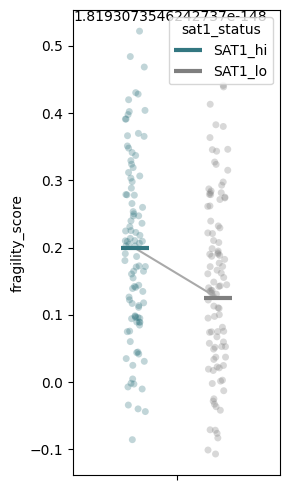

In [16]:
%matplotlib inline
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42


fig, ax = plt.subplots()

palette = {
    'SAT1_hi': '#337781',
    'SAT1_lo': '#7f7f7f'
}

generate_stripplot(
    score_df,
    'fragility_score',
    'sat1_status',
    100,
    palette,
    ax
)

fig.set_figheight(5)
fig.set_figwidth(3)
fig.tight_layout()
#fig.savefig('../plots/tregs.tissue.scps.sat1.fragility.pdf')

# TRM scores

In [4]:
genes = pd.read_csv(
    '../resource/10X_GeneLists_with_annotation.csv'
)
genes = genes.loc[genes.List.str.startswith('TRM'), ['List', 'Name']]
genes

,List,Name
124,TRM homing and retention,CD69
125,TRM homing and retention,ITGAE
126,TRM homing and retention,ITGA1
127,TRM homing and retention,CCR9
128,TRM homing and retention,PTPN2
...,...,...
184,TRM niche signals,CCL17
185,TRM niche signals,CCL22
186,TRM niche signals,IFNA1
187,TRM niche signals,IFNB1


In [5]:
genes_in_data = set(adata.var.index)
gene_set = set(genes.Name)
genes_to_retain = genes_in_data & gene_set
', '.join(genes_in_data & gene_set)

'LGALS3, CCR8, FASLG, TGFB2, IL7, ITGAL, BCL2A1, IL7R, TGFB1, CXCL9, PRDM1, BHLHE40, FDFT1, XCL1, CCL2, CCL17, S1PR5, FOXO3, NR4A2, IL33, MVK, NR4A1, IL15RA, TOX, TGIF1, IRF4, CCL8, JUNB, DGAT1, PTPN2, CCL20, AHR, GZMB, FOSL2, P2RX7, CCR5, ZNF683, SKIL, ITGAE, CXCR6, ID2, BCL2L11, FABP5, IL2, ID3, CD69, SMURF1, RUNX3, CCL3, CCL22, IL15, CXCL10, TNF, FDPS, CD28, IFNG, CCL4, CCR10, NR4A3, CCR4, GOT1, IFNB1, ITGA1'

In [6]:
genes = genes.loc[genes.Name.isin(genes_to_retain), :]
genes

,List,Name
124,TRM homing and retention,CD69
125,TRM homing and retention,ITGAE
126,TRM homing and retention,ITGA1
128,TRM homing and retention,PTPN2
129,TRM homing and retention,XCL1
...,...,...
183,TRM niche signals,CXCL10
184,TRM niche signals,CCL17
185,TRM niche signals,CCL22
187,TRM niche signals,IFNB1


In [10]:
score_dfs = {}
for key, gene_set in genes.groupby('List'):
    score_dfs[key] = pd.DataFrame(
        {
            'score': score.gene_module_score(adata, gene_set.Name),
            'sat1_status': adata.obs.sat1_status_majority_vote,
            'sat1_expression': adata[:, 'SAT1'].X.toarray().flatten()
        },
        index = adata.obs.index
    )
    print(key, ', '.join(gene_set.Name))

TRM differentiation RUNX3, NR4A2, NR4A3, JUNB, FOSL2, TOX, FOXO3, IRF4
TRM effector function ID3, ID2, CCL3, CCL4, CCR5, IL2, IFNG, TNF, FASLG, GZMB
TRM homing and retention CD69, ITGAE, ITGA1, PTPN2, XCL1, P2RX7, S1PR5, CCR4, CCR8, CCR10, ZNF683
TRM long term maintenance NR4A1, AHR, SKIL, SMURF1, TGIF1, PRDM1, BCL2A1, BCL2L11, IL7R, IL15RA, CD28, CXCR6, LGALS3
TRM metabolic fitness BHLHE40, GOT1, DGAT1, FABP5, FDPS, MVK, FDFT1
TRM niche signals CCL2, CCL20, CCL8, IL15, IL7, TGFB1, TGFB2, IL33, CXCL9, CXCL10, CCL17, CCL22, IFNB1, ITGAL


TRM differentiation
TRM effector function
TRM homing and retention
TRM long term maintenance
TRM metabolic fitness
TRM niche signals


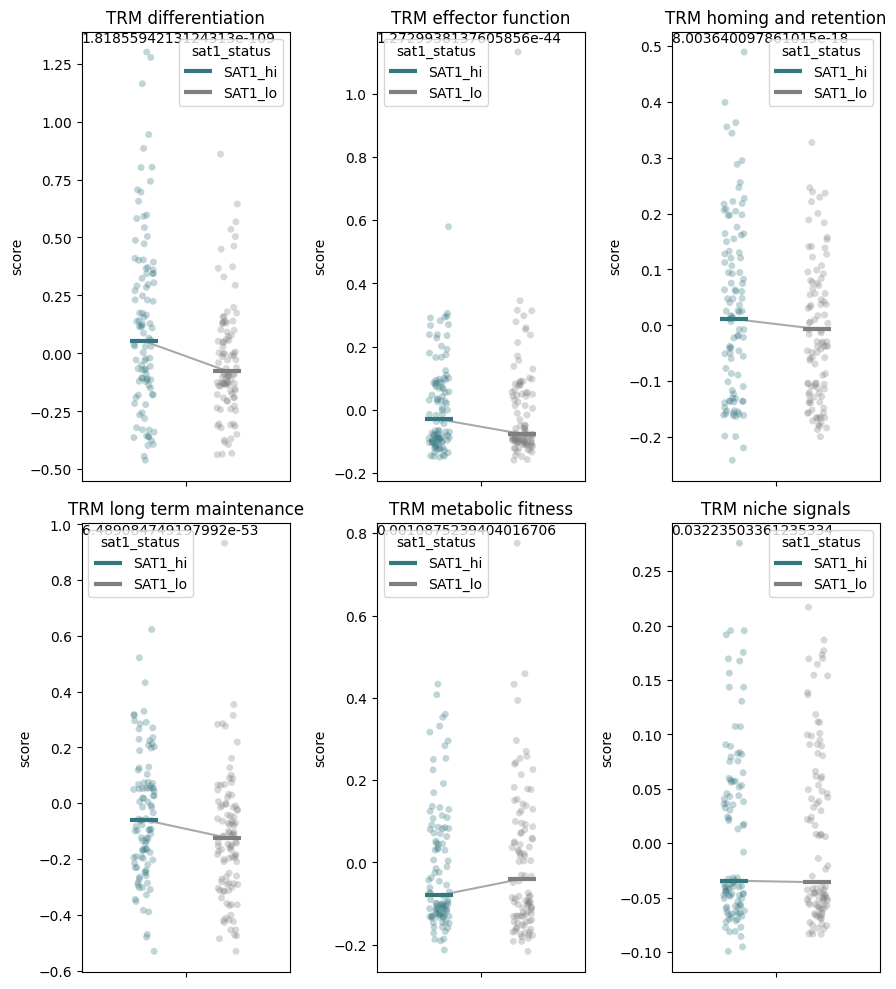

In [9]:
%matplotlib inline
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42


fig, axs = plt.subplots(2, 3)

palette = {
    'SAT1_hi': '#337781',
    'SAT1_lo': '#7f7f7f'
}

for ax, (key, score_df) in zip(axs.reshape(6), score_dfs.items()):
    print(key)
    generate_stripplot(
        score_df,
        'score',
        'sat1_status',
        100,
        palette,
        ax
    )
    ax.set_title(key)


fig.set_figheight(10)
fig.set_figwidth(9)
fig.tight_layout()
fig.savefig('../plots/trm_gene_scores.pdf')